In [1]:
import re
import pandas as pd
import numpy as np
from sklearn import ensemble, model_selection, decomposition, preprocessing, tree, svm, linear_model
from matplotlib import pyplot as plt

In [26]:
# 又一步探索泰坦尼克号数据
data = pd.read_csv('./data/train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [28]:
data.drop(['Cabin'], axis=1, inplace=True)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 76.6+ KB


In [30]:
data.drop(index=data[data['Embarked'].isnull()].index, inplace=True)

In [31]:
# 重置索引 
data.index = range(0, data.shape[0])

In [32]:
data.shape

(889, 11)

In [33]:
[*data.index] == [*range(0, 889)]

True

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 11 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            712 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 76.5+ KB


In [35]:

# 对Sex进行独热编码
en = preprocessing.OneHotEncoder()
en_data = en.fit_transform(data['Sex'].values.reshape(-1, 1)).toarray()
data = pd.concat([data, pd.DataFrame(en_data, columns=['female', 'male'], index=data.index, dtype=int)], axis=1)



In [45]:
# # 对Embarked进行独热编码
en = preprocessing.OneHotEncoder()
en_data = en.fit_transform(data['Embarked'].values.reshape(-1, 1)).toarray()
data = pd.concat([data, pd.DataFrame(en_data, columns=['Embarked_C', 'Embarked_Q','Embarked_S'], index=data.index, dtype=int)], axis=1)
en.categories_

[array(['C', 'Q', 'S'], dtype=object)]

In [56]:
# columns 部分重命名
data = data.rename(columns={"female": "Female", "male": "Male"})

In [48]:
# 接下来删除Sex和Embarked
data.drop(['Sex', 'Embarked', 'Ticket'], axis=1, inplace=True)

In [50]:
pd.qcut(data['Fare'], 4).value_counts()

(7.896, 14.454]    224
(-0.001, 7.896]    223
(14.454, 31.0]     222
(31.0, 512.329]    220
Name: Fare, dtype: int64

In [51]:
pd.cut(data['Fare'], 4).value_counts()

(-0.512, 128.082]     851
(128.082, 256.165]     29
(256.165, 384.247]      6
(384.247, 512.329]      3
Name: Fare, dtype: int64

In [52]:
# 处理票价 
data['CategoricalFare'] = pd.qcut(data['Fare'], 4, labels=[0, 1, 2, 3])


In [54]:
data.drop(['Fare'], axis=1, inplace=True)

In [58]:
data.to_csv('./temp/train_data_04.csv', index=False)

In [59]:
# 把Name删掉
data.drop(['Name'], axis=1, inplace=True)

In [60]:
data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Female,Male,Embarked_C,Embarked_Q,Embarked_S,CategoricalFare
0,1,0,3,22.0,1,0,0,1,0,0,1,0
1,2,1,1,38.0,1,0,1,0,1,0,0,3
2,3,1,3,26.0,0,0,1,0,0,0,1,1
3,4,1,1,35.0,1,0,1,0,0,0,1,3
4,5,0,3,35.0,0,0,0,1,0,0,1,1


In [61]:
# 只有age有缺失项 尝试使用随机森林回归进行填充
# 儿童6到10少年11到15青年16到1818到35成年40开始中年60开始老年
x_train = data.loc[data['Age'].notnull(), data.columns != 'Age']
y_train = data.loc[data['Age'].notnull(), 'Age']

x_test = data.loc[data['Age'].isnull(), data.columns != 'Age']
y_test = data.loc[data['Age'].isnull(), 'Age']

# 接下来开始使用随机森立回归开始插值  以Age为标签值 剩下的其他的作为特征列
clf = ensemble.RandomForestRegressor(n_estimators=100, n_jobs=-1).fit(x_train, y_train)
pred = clf.predict(x_test)

data.loc[data['Age'].isnull(), 'Age'] = pred

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 12 columns):
PassengerId        889 non-null int64
Survived           889 non-null int64
Pclass             889 non-null int64
Age                889 non-null float64
SibSp              889 non-null int64
Parch              889 non-null int64
Female             889 non-null int64
Male               889 non-null int64
Embarked_C         889 non-null int64
Embarked_Q         889 non-null int64
Embarked_S         889 non-null int64
CategoricalFare    889 non-null category
dtypes: category(1), float64(1), int64(10)
memory usage: 77.5 KB


In [71]:
bins = [0, 12, 18, 40, 65, 100]
data['CategoricalAge'] = pd.cut(data['Age'], bins, labels=[0, 1, 2, 3, 4])

In [73]:
# 把Name删掉
data.drop(['Age'], axis=1, inplace=True)

In [74]:
data.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Female,Male,Embarked_C,Embarked_Q,Embarked_S,CategoricalFare,CategoricalAge
0,1,0,3,1,0,0,1,0,0,1,0,2
1,2,1,1,1,0,1,0,1,0,0,3,2
2,3,1,3,0,0,1,0,0,0,1,1,2
3,4,1,1,1,0,1,0,0,0,1,3,2
4,5,0,3,0,0,0,1,0,0,1,1,2


In [78]:
[*data['PassengerId'].astype(int)] == [*range(0, data.shape[0])]

False

In [93]:
data['isAlone'] = ((data['SibSp'] + data['Parch']) == 1).astype(int)

In [94]:
data.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Female,Male,Embarked_C,Embarked_Q,Embarked_S,CategoricalFare,CategoricalAge,isAlone
0,1,0,3,1,0,0,1,0,0,1,0,2,1
1,2,1,1,1,0,1,0,1,0,0,3,2,1
2,3,1,3,0,0,1,0,0,0,1,1,2,0
3,4,1,1,1,0,1,0,0,0,1,3,2,1
4,5,0,3,0,0,0,1,0,0,1,1,2,0


In [115]:
# 然后开始拆分训练集和测试集
# 先分训练集和测试集 
X = data.iloc[:, 2:-1]
y = data.loc[:, 'Survived']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=66)

In [116]:
X.shape

(889, 10)

In [117]:
X_train.shape

(622, 10)

In [118]:
y_train.shape

(622,)

In [119]:
for i in [X_train, X_test, y_train, y_test]:
    i.index = range(i.shape[0])

In [120]:
# 接下来开始建立模型 预测数据 因为在单个决策树的效果没有在集成算法上好
# 所以直接上集成算法--随机森林
clf = ensemble.RandomForestClassifier(n_estimators=100, random_state=66).fit(X_train, y_train)
clf.score(X_test, y_test)
# 0.8277153558052435

0.8277153558052435

0.8324310520939735 11


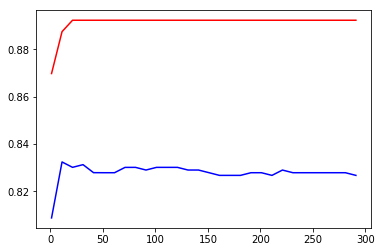

In [121]:

# n_estimators的学习曲线  寻找最优化的n_estimators
train_scores = []
test_scores = []
x_ticks = [*range(1, 300, 10)]
for i in range(1, 300, 10):
    clf = ensemble.RandomForestClassifier(n_estimators=i, random_state=66)
    train_score = clf.fit(X_train, y_train).score(X_train, y_train)
    train_scores.append(train_score)
    
    mean_score = model_selection.cross_val_score(clf, X, y, cv=10).mean()
    test_scores.append(mean_score)
plt.plot(x_ticks, train_scores, c='r')
plt.plot(x_ticks, test_scores, c='b')
print(max(test_scores), x_ticks[test_scores.index(max(test_scores))])
plt.show()
# 0.8324310520939735 11

0.8346782431052094 11


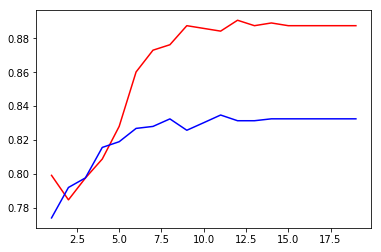

In [92]:
train_scores = []
test_scores = []
x_ticks = [*range(1, 20)]
for i in range(1, 20):
    clf = ensemble.RandomForestClassifier(n_estimators=11, random_state=66, max_depth=i)
    train_score = clf.fit(X_train, y_train).score(X_train, y_train)
    train_scores.append(train_score)
    
    mean_score = model_selection.cross_val_score(clf, X, y, cv=10).mean()
    test_scores.append(mean_score)
plt.plot(x_ticks, train_scores, c='r')
plt.plot(x_ticks, test_scores, c='b')
print(max(test_scores), x_ticks[test_scores.index(max(test_scores))])
plt.show()

In [122]:
gbc = ensemble.GradientBoostingClassifier(n_estimators=100)
score = gbc.fit(X_train, y_train).score(X_test, y_test)
score_mean = model_selection.cross_val_score(gbc, X, y, cv=10).mean()
print(score, '------', score_mean)

0.8314606741573034 ------ 0.8391726251276813


0.8402962206332993 81


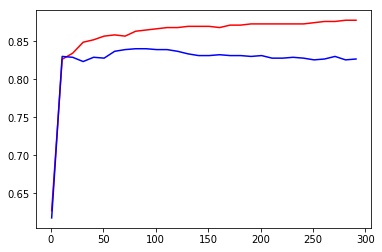

In [123]:
# n_estimators的学习曲线  寻找最优化的n_estimators
train_scores = []
test_scores = []
x_ticks = [*range(1, 300, 10)]
for i in range(1, 300, 10):
    clf = ensemble.GradientBoostingClassifier(n_estimators=i, random_state=66)
    train_score = clf.fit(X_train, y_train).score(X_train, y_train)
    train_scores.append(train_score)
    
    mean_score = model_selection.cross_val_score(clf, X, y, cv=10).mean()
    test_scores.append(mean_score)
plt.plot(x_ticks, train_scores, c='r')
plt.plot(x_ticks, test_scores, c='b')
print(max(test_scores), x_ticks[test_scores.index(max(test_scores))])
plt.show()

0.8414198161389173 74


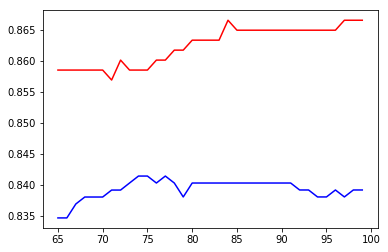

In [124]:
# 细化n_estimators的学习曲线  寻找最优化的n_estimators
train_scores = []
test_scores = []
x_ticks = [*range(65, 100, 1)]
for i in range(65, 100, 1):
    clf = ensemble.GradientBoostingClassifier(n_estimators=i, random_state=66)
    train_score = clf.fit(X_train, y_train).score(X_train, y_train)
    train_scores.append(train_score)
    
    mean_score = model_selection.cross_val_score(clf, X, y, cv=10).mean()
    test_scores.append(mean_score)
plt.plot(x_ticks, train_scores, c='r')
plt.plot(x_ticks, test_scores, c='b')
print(max(test_scores), x_ticks[test_scores.index(max(test_scores))])
plt.show()

0.8312819203268642 8


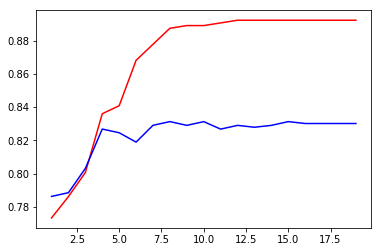

In [125]:
train_scores = []
test_scores = []
x_ticks = [*range(1, 20)]
for i in range(1, 20):
    clf = ensemble.RandomForestClassifier(n_estimators=74, random_state=66, max_depth=i)
    train_score = clf.fit(X_train, y_train).score(X_train, y_train)
    train_scores.append(train_score)
    
    mean_score = model_selection.cross_val_score(clf, X, y, cv=10).mean()
    test_scores.append(mean_score)
plt.plot(x_ticks, train_scores, c='r')
plt.plot(x_ticks, test_scores, c='b')
print(max(test_scores), x_ticks[test_scores.index(max(test_scores))])
plt.show()

In [129]:
np.linspace(1, 100, 10).astype(int)

array([  1,  12,  23,  34,  45,  56,  67,  78,  89, 100])

0.8312819203268642 1


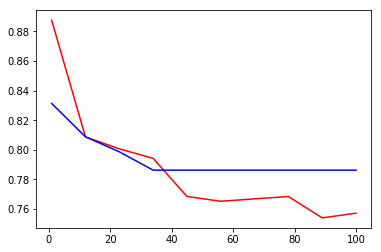

In [130]:
# 接着调min_samples_leaf
train_scores = []
test_scores = []
x_ticks = np.linspace(1, 100, 10).astype(int)
for i in x_ticks:
    clf = ensemble.RandomForestClassifier(n_estimators=74, 
                                          random_state=66, 
                                          max_depth=8, 
                                          min_samples_leaf=i)
    train_score = clf.fit(X_train, y_train).score(X_train, y_train)
    train_scores.append(train_score)
    
    mean_score = model_selection.cross_val_score(clf, X, y, cv=10).mean()
    test_scores.append(mean_score)
plt.plot(x_ticks, train_scores, c='r')
plt.plot(x_ticks, test_scores, c='b')
print(max(test_scores), x_ticks[test_scores.index(max(test_scores))])
plt.show()

0.8324182839632277 12


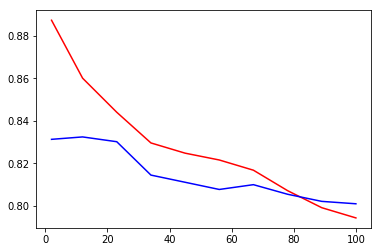

In [132]:
train_scores = []
test_scores = []
x_ticks = np.linspace(2, 100, 10).astype(int)
for i in x_ticks:
    clf = ensemble.RandomForestClassifier(n_estimators=74, 
                                          random_state=66, 
                                          max_depth=8, 
                                          min_samples_leaf=1,
                                          min_samples_split=i)
    train_score = clf.fit(X_train, y_train).score(X_train, y_train)
    train_scores.append(train_score)
    
    mean_score = model_selection.cross_val_score(clf, X, y, cv=10).mean()
    test_scores.append(mean_score)
plt.plot(x_ticks, train_scores, c='r')
plt.plot(x_ticks, test_scores, c='b')
print(max(test_scores), x_ticks[test_scores.index(max(test_scores))])
plt.show()